# Timeseries

Pandas started out in the financial world, so naturally it has strong timeseries support.

The first half of this post will look at pandas' capabilities for manipulating time series data.
The second half will discuss modelling time series data with statsmodels.

In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Let's grab some stock data for Goldman Sachs using the [`pandas-datareader`](http://pandas-datareader.readthedocs.io/en/latest/) package, which spun off of pandas:

In [3]:
gs = web.DataReader("GS", data_source='yahoo', start='2006-01-01',
                    end='2010-01-01')
gs.head().round(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,129.44,124.23,126.70,128.87,6188700.0,107.57
2006-01-04,128.91,126.38,127.35,127.09,4861600.0,106.09
2006-01-05,127.32,125.61,126.00,127.04,3717400.0,106.05
2006-01-06,129.25,127.29,127.29,128.84,4319600.0,107.55
2006-01-09,130.62,128.00,128.50,130.39,4723500.0,108.84


There isn't a special data-container just for time series in pandas, they're just `Series` or `DataFrame`s with a `DatetimeIndex`.

## Special Slicing

Looking at the elements of `gs.index`, we see that `DatetimeIndex`es are made up of `pandas.Timestamp`s:

In [4]:
gs.index[0]

Timestamp('2006-01-03 00:00:00')

A `Timestamp` is mostly compatible with the `datetime.datetime` class, but much amenable to storage in arrays.

Working with `Timestamp`s can be awkward, so Series and DataFrames with `DatetimeIndexes` have some special slicing rules.
The first special case is *partial-string indexing*. Say we wanted to select all the days in 2006. Even with `Timestamp`'s convenient constructors, it's a pai

In [4]:
gs.loc[pd.Timestamp('2006-01-01'):pd.Timestamp('2006-12-31')].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,112.337547,6188700
2006-01-04,127.349998,128.910004,126.379997,127.089996,110.785889,4861600
2006-01-05,126.000000,127.320000,125.610001,127.040001,110.742340,3717400
2006-01-06,127.290001,129.250000,127.290001,128.839996,112.311401,4319600
2006-01-09,128.500000,130.619995,128.000000,130.389999,113.662605,4723500


Thanks to partial-string indexing, it's as simple as

In [9]:
gs.loc['2006'].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,129.440002,124.230003,126.699997,128.869995,6188700.0,107.574997
2006-01-04,128.910004,126.379997,127.349998,127.089996,4861600.0,106.089142
2006-01-05,127.320000,125.610001,126.000000,127.040001,3717400.0,106.047379
2006-01-06,129.250000,127.290001,127.290001,128.839996,4319600.0,107.549896
2006-01-09,130.619995,128.000000,128.500000,130.389999,4723500.0,108.843857


In [10]:
gs.loc['2006':'2008']

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,129.440002,124.230003,126.699997,128.869995,6188700.0,107.574997
2006-01-04,128.910004,126.379997,127.349998,127.089996,4861600.0,106.089142
2006-01-05,127.320000,125.610001,126.000000,127.040001,3717400.0,106.047379
2006-01-06,129.250000,127.290001,127.290001,128.839996,4319600.0,107.549896
2006-01-09,130.619995,128.000000,128.500000,130.389999,4723500.0,108.843857
...,...,...,...,...,...,...
2008-12-24,76.739998,75.260002,75.540001,76.440002,3166000.0,65.326050
2008-12-26,77.440002,75.309998,76.830002,75.970001,4657300.0,64.924377
2008-12-29,77.110001,75.029999,76.430000,76.559998,6322300.0,65.428574


Since label slicing is inclusive, this slice selects any observation where the year is 2006.

The second "convenience" is `__getitem__` (square-bracket) fall-back indexing. I'm only going to mention it here, with the caveat that you should never use it.
DataFrame `__getitem__` typically looks in the column: `gs['2006']` would search `gs.columns` for `'2006'`, not find it, and raise a `KeyError`. But DataFrames with a `DatetimeIndex` catch that `KeyError` and try to slice the index.
If it succeeds in slicing the index, the result like `gs.loc['2006']` is returned.
If it fails, the `KeyError` is re-raised.
This is confusing because in pretty much every other case `DataFrame.__getitem__` works on columns, and it's fragile because if you happened to have a column `'2006'` you *would* get just that column, and no fall-back indexing would occur. Just use `gs.loc['2006']` when slicing DataFrame indexes.


In [47]:
# get june data in 2006 and 2007
gs.loc[gs.index.month==6].loc['2006':'2007']

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-06-01,153.589996,150.190002,150.919998,153.550003,4206200.0,128.683853
2006-06-02,157.000000,153.600006,155.500000,154.089996,4253400.0,129.136398
2006-06-05,156.289993,149.850006,154.949997,150.399994,5400000.0,126.043922
2006-06-06,152.059998,147.500000,151.389999,149.240005,6562400.0,125.071854
2006-06-07,152.529999,148.300003,149.250000,149.949997,4319900.0,125.666870
2006-06-08,150.669998,144.500000,148.800003,149.759995,7885500.0,125.507637
2006-06-09,152.100006,148.990005,151.000000,149.889999,4407300.0,125.616577
2006-06-12,150.720001,145.000000,150.300003,145.000000,5860300.0,121.518509
2006-06-13,145.500000,138.009995,144.500000,139.250000,15679700.0,116.699631


## Special Methods

### Resampling

Resampling is similar to a `groupby`: you split the time series into groups (5-day buckets below), apply a function to each group (`mean`), and combine the result (one row per group).

In [37]:
gs.resample("5d").mean().head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,128.730001,125.877501,126.834999,127.959997,4.771825e+06,106.815353
2006-01-08,132.645000,130.205002,130.349998,131.660000,4.664300e+06,109.903973
2006-01-13,133.395004,131.244995,131.510002,132.924995,3.258250e+06,110.959911
2006-01-18,133.853333,131.656667,132.210002,132.543335,4.997767e+06,110.709785
2006-01-23,136.083997,133.310001,133.771997,135.153998,3.968500e+06,113.031767


In [38]:
gs.resample("W").agg(['mean', 'sum']).head()

High                     Low                    Open  \
                  mean         sum        mean         sum        mean   
Date                                                                     
2006-01-08  128.730001  514.920006  125.877501  503.510002  126.834999   
2006-01-15  132.848001  664.240005  130.544000  652.720001  130.684000   
2006-01-22  133.672501  534.690002  131.389999  525.559998  131.907501   
2006-01-29  136.083997  680.419983  133.310001  666.550003  133.771997   
2006-02-05  142.467999  712.339996  139.937997  699.689987  140.900000   

                             Close                 Volume              \
                   sum        mean         sum       mean         sum   
Date                                                                    
2006-01-08  507.339996  127.959997  511.839989  4771825.0  19087300.0   
2006-01-15  653.419998  131.979999  659.899994  4310420.0  21552100.0   
2006-01-22  527.630005  132.555000  530.220001  4653725.0  18614900.0   
2006-01-29  668.859985  135.153998  675.769989  3968500.0  19842500.0   
2006-02-05  704.500000  141.618002  708.090012  3920120.0  19600600.0   

             Adj Close              
                  mean         sum  
Date                                
2006-01-08  106.815353  427.261414  
2006-01-15  110.171089  550.855446  
2006-01-22  110.702406  442.809624  
2006-01-29  113.031767  565.158836  
2006-02-05  118.437737  592.188683

You can up-sample to convert to a higher frequency.
The new points are filled with NaNs.

In [39]:
gs.resample("6H").mean().head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03 00:00:00,129.440002,124.230003,126.699997,128.869995,6188700.0,107.574997
2006-01-03 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04 00:00:00,128.910004,126.379997,127.349998,127.089996,4861600.0,106.089142


In [44]:
gs.Close.resample('M').agg(["mean","min","max"]).head()

,mean,min,max
Date,,,
2006-01-31,132.942498,127.040001,141.250000
2006-02-28,142.752106,139.479996,145.899994
2006-03-31,148.801304,140.720001,156.960007
2006-04-30,162.541053,158.119995,168.550003
2006-05-31,154.132726,143.699997,165.750000


In [78]:
gs.Close.resample('M', kind='period').sum().head()

Date
2006-01    2658.849968
2006-02    2712.290009
2006-03    3422.429993
2006-04    3088.279999
2006-05    3390.919983
Freq: M, Name: Close, dtype: float64

In [89]:
gs.Close.resample('MS').sum().head()

Date
2006-01-01    2658.849968
2006-02-01    2712.290009
2006-03-01    3422.429993
2006-04-01    3088.279999
2006-05-01    3390.919983
Freq: MS, Name: Close, dtype: float64

In [80]:
gs.Close.loc['2006-01'].sum()

2658.849967956543

### Rolling / Expanding / EW

These methods aren't unique to `DatetimeIndex`es, but they often make sense with time series, so I'll show them here.

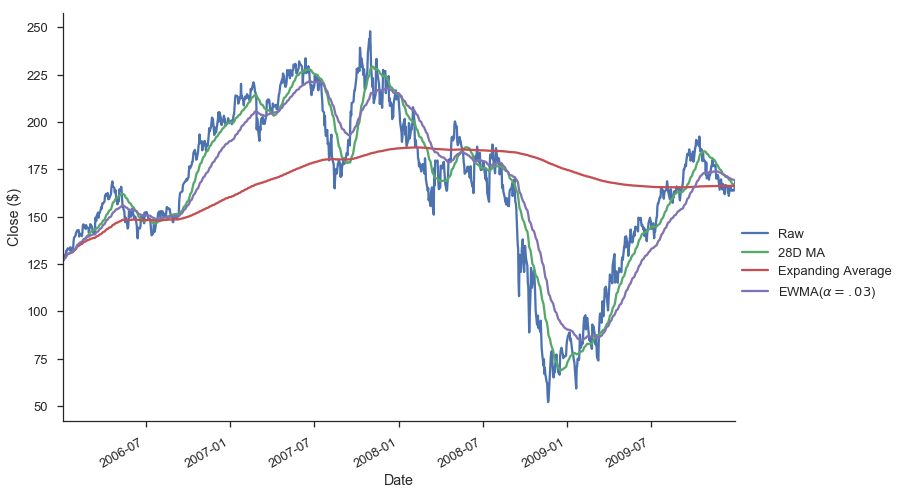

In [9]:
gs.Close.plot(label='Raw')
gs.Close.rolling(28).mean().plot(label='28D MA')
gs.Close.expanding().mean().plot(label='Expanding Average')
gs.Close.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)')

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

Each of `.rolling`, `.expanding`, and `.ewm` return a deferred object, similar to a GroupBy.

In [45]:
roll = gs.Close.rolling(30, center=True)
roll

Rolling [window=30,center=True,axis=0]

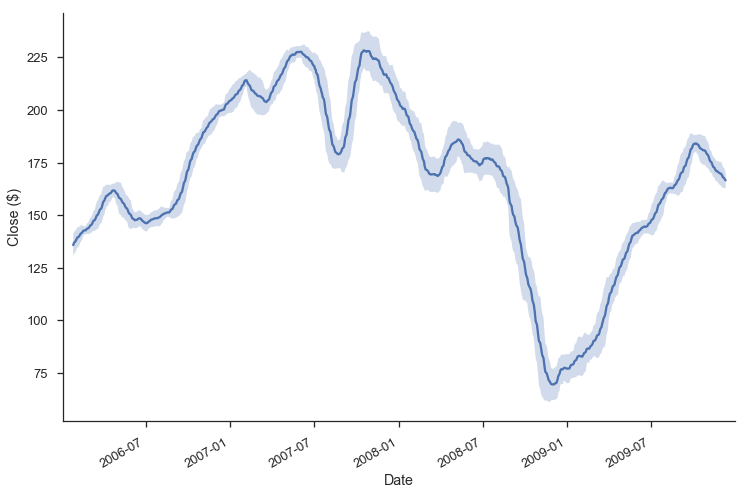

In [11]:
m = roll.agg(['mean', 'std'])
ax = m['mean'].plot()
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                alpha=.25)
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

## Grab Bag

### Offsets

These are similar to `dateutil.relativedelta`, but works with arrays.

In [48]:
gs.index

DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2009-12-17', '2009-12-18', '2009-12-21', '2009-12-22',
               '2009-12-23', '2009-12-24', '2009-12-28', '2009-12-29',
               '2009-12-30', '2009-12-31'],
              dtype='datetime64[ns]', name='Date', length=1007, freq=None)

In [49]:
gs.index + pd.DateOffset(months=3, days=-2)

DatetimeIndex(['2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-07', '2006-04-08', '2006-04-09', '2006-04-10',
               '2006-04-11', '2006-04-15',
               ...
               '2010-03-15', '2010-03-16', '2010-03-19', '2010-03-20',
               '2010-03-21', '2010-03-22', '2010-03-26', '2010-03-27',
               '2010-03-28', '2010-03-29'],
              dtype='datetime64[ns]', name='Date', length=1007, freq=None)

In [60]:
ts=pd.Series(gs.index.copy())

In [69]:
# add 5 days 
ts+pd.DateOffset(days=5)

0      2006-01-08
1      2006-01-09
2      2006-01-10
3      2006-01-11
4      2006-01-14
          ...    
1002   2009-12-29
1003   2010-01-02
1004   2010-01-03
1005   2010-01-04
1006   2010-01-05
Name: Date, Length: 1007, dtype: datetime64[ns]

In [70]:
# replace day with 5
ts + pd.DateOffset(day=5)

0      2006-01-05
1      2006-01-05
2      2006-01-05
3      2006-01-05
4      2006-01-05
          ...    
1002   2009-12-05
1003   2009-12-05
1004   2009-12-05
1005   2009-12-05
1006   2009-12-05
Name: Date, Length: 1007, dtype: datetime64[ns]

### Holiday Calendars

There are a whole bunch of special calendars, useful for traders probabaly.

In [81]:
from pandas.tseries.holiday import USColumbusDay

In [82]:
USColumbusDay.dates('2015-01-01', '2020-01-01')

DatetimeIndex(['2015-10-12', '2016-10-10', '2017-10-09', '2018-10-08',
               '2019-10-14'],
              dtype='datetime64[ns]', freq='WOM-2MON')

### Timezones

Pandas works with `pytz` for nice timezone-aware datetimes.
The typical workflow is

1. localize timezone-naive timestamps to some timezone
2. convert to desired timezone

If you already have timezone-aware Timestamps, there's no need for step one. 

In [83]:
# tz naiive -> tz aware..... to desired UTC
gs.tz_localize('US/Eastern').tz_convert('UTC').head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03 05:00:00+00:00,129.440002,124.230003,126.699997,128.869995,6188700.0,107.574997
2006-01-04 05:00:00+00:00,128.910004,126.379997,127.349998,127.089996,4861600.0,106.089142
2006-01-05 05:00:00+00:00,127.320000,125.610001,126.000000,127.040001,3717400.0,106.047379
2006-01-06 05:00:00+00:00,129.250000,127.290001,127.290001,128.839996,4319600.0,107.549896
2006-01-09 05:00:00+00:00,130.619995,128.000000,128.500000,130.389999,4723500.0,108.843857


## Modeling Time Series

The rest of this post will focus on time series in the econometric sense.
My indented reader for this section isn't all that clear, so I apologize upfront for any sudden shifts in complexity.
I'm roughly targeting material that could be presented in a first or second semester applied statisctics course.
What follows certainly isn't a replacement for that.
Any formality will be restricted to footnotes for the curious.
I've put a whole bunch of resources at the end for people earger to learn more.

We'll focus on modelling Average Monthly Flights. Let's download the data.
If you've been following along in the series, you've seen most of this code before, so feel free to skip.

In [84]:
import os
import io
import glob
import zipfile
from utils import download_timeseries

import statsmodels.api as sm


def download_many(start, end):
    months = pd.period_range(start, end=end, freq='M')
    # We could easily parallelize this loop.
    for i, month in enumerate(months):
        download_timeseries(month)


def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.

    2014-01-01,1149.0 -> 2014-01-01T11:49:00
    '''
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return  pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
        return datetime_part
    df[columns] = df[columns].apply(converter)
    return df


def read_one(fp):
    df = (pd.read_csv(fp, encoding='latin1')
            .rename(columns=str.lower)
            .drop('unnamed: 6', axis=1)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time',
                                     'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date'])))
    return df

In [98]:
store = 'data/ts.hdf5'

if not os.path.exists(store):
    #download_many('2003-10-01', '2016-01-01')

#     zips = glob.glob(os.path.join('data', 'timeseries', '*.zip'))
#     dfs = [read_one(fp) for fp in zips]
#     df = pd.concat(dfs, ignore_index=True)

#     df['origin'] = df['origin'].astype('category')
    df.to_hdf(store, 'ts', format='table')
else:
    df = pd.read_hdf(store, 'ts')

In [99]:
with pd.option_context('display.max_rows', 100):
    print(df.dtypes)

fl_date         datetime64[ns]
origin                category
crs_dep_time    datetime64[ns]
dep_time        datetime64[ns]
crs_arr_time    datetime64[ns]
arr_time        datetime64[ns]
dtype: object


We can calculate the historical values with a resample.

In [100]:
daily = df.fl_date.value_counts().sort_index()
y = daily.resample('MS').mean()
y.head()

2000-01-01    15176.677419
2000-02-01    15327.551724
2000-03-01    15578.838710
2000-04-01    15442.100000
2000-05-01    15448.677419
Freq: MS, Name: fl_date, dtype: float64

Note that I use the `"MS"` frequency code there.
Pandas defaults to end of month (or end of year).
Append an `'S'` to get the start.

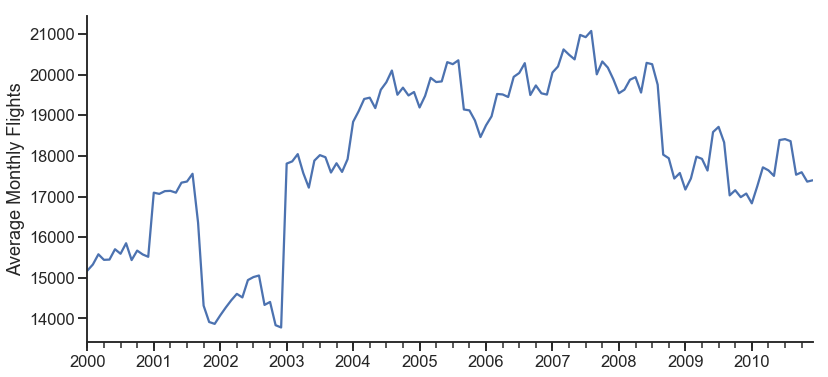

In [103]:
ax = y.plot(figsize=(13,6))
ax.set(ylabel='Average Monthly Flights')
sns.despine()

In [104]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

One note of warning: I'm using the development version of statsmodels (commit `de15ec8` to be precise).
Not all of the items I've shown here are available in the currently-released version.

Think back to a typical regression problem, ignoring anything to do with time series for now.
The usual task is to predict some value $y$ using some a linear combination of features in $X$.

$$y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$

When working with time series, some of the most important (and sometimes *only*) features are the previous, or *lagged*, values of $y$.

Let's start by trying just that "manually": running a regression of `y` on lagged values of itself.
We'll see that this regression suffers from a few problems: multicollinearity, autocorrelation, non-stationarity, and seasonality.
I'll explain what each of those are in turn and why they're problems.
Afterwards, we'll use a second model, seasonal ARIMA, which handles those problems for us.

First, let's create a dataframe with our lagged values of `y` using the `.shift` method, which shifts the index `i` periods, so it lines up with that observation.

In [160]:
y.shift(1)

2000-01-01             NaN
2000-02-01    15176.677419
2000-03-01    15327.551724
2000-04-01    15578.838710
2000-05-01    15442.100000
                  ...     
2010-08-01    18412.516129
2010-09-01    18361.838710
2010-10-01    17536.900000
2010-11-01    17597.387097
2010-12-01    17366.633333
Freq: MS, Name: fl_date, Length: 132, dtype: float64

In [161]:
pd.concat([y.shift(i) for i in range(6)], axis=1,
               keys=['y'] + ['L%s' % i for i in range(1, 6)])[:10]

,y,L1,L2,L3,L4,L5
2000-01-01,15176.677419,NaN,NaN,NaN,NaN,NaN
2000-02-01,15327.551724,15176.677419,NaN,NaN,NaN,NaN
2000-03-01,15578.838710,15327.551724,15176.677419,NaN,NaN,NaN
2000-04-01,15442.100000,15578.838710,15327.551724,15176.677419,NaN,NaN
2000-05-01,15448.677419,15442.100000,15578.838710,15327.551724,15176.677419,NaN
2000-06-01,15703.333333,15448.677419,15442.100000,15578.838710,15327.551724,15176.677419
2000-07-01,15591.677419,15703.333333,15448.677419,15442.100000,15578.838710,15327.551724
2000-08-01,15850.516129,15591.677419,15703.333333,15448.677419,15442.100000,15578.838710
2000-09-01,15436.566667,15850.516129,15591.677419,15703.333333,15448.677419,15442.100000
2000-10-01,15669.709677,15436.566667,15850.516129,15591.677419,15703.333333,15448.677419


In [162]:
X = (pd.concat([y.shift(i) for i in range(6)], axis=1,
               keys=['y'] + ['L%s' % i for i in range(1, 6)])
       .dropna())
X.head()

,y,L1,L2,L3,L4,L5
2000-06-01,15703.333333,15448.677419,15442.100000,15578.838710,15327.551724,15176.677419
2000-07-01,15591.677419,15703.333333,15448.677419,15442.100000,15578.838710,15327.551724
2000-08-01,15850.516129,15591.677419,15703.333333,15448.677419,15442.100000,15578.838710
2000-09-01,15436.566667,15850.516129,15591.677419,15703.333333,15448.677419,15442.100000
2000-10-01,15669.709677,15436.566667,15850.516129,15591.677419,15703.333333,15448.677419


In [163]:
X.tail()

,y,L1,L2,L3,L4,L5
2010-08-01,18361.838710,18412.516129,18389.566667,17507.967742,17644.333333,17718.129032
2010-09-01,17536.900000,18361.838710,18412.516129,18389.566667,17507.967742,17644.333333
2010-10-01,17597.387097,17536.900000,18361.838710,18412.516129,18389.566667,17507.967742
2010-11-01,17366.633333,17597.387097,17536.900000,18361.838710,18412.516129,18389.566667
2010-12-01,17399.419355,17366.633333,17597.387097,17536.900000,18361.838710,18412.516129


We can fit the lagged model using statsmodels (which uses [patsy](http://patsy.readthedocs.org) to translate the formula string to a design matrix).

In [132]:
mod_lagged = smf.ols('y ~ trend + L1 + L2 + L3 + L4 + L5',
                     data=X.assign(trend=np.arange(len(X))))
res_lagged = mod_lagged.fit()
res_lagged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     191.2
Date:                Sun, 17 May 2020   Prob (F-statistic):           5.92e-59
Time:                        13:34:42   Log-Likelihood:                -988.44
No. Observations:                 127   AIC:                             1991.
Df Residuals:                     120   BIC:                             2011.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1028.6309    576.924      1.783      0.077    -113.639    2170.901
trend          0.2184      1.759      0.124      0.901      -3.265       3.701
L1             1.0186      0.091     11.165      0.000       0.838       1.199
L2            -0.0569      0.130     -0.437      0.663      -0.315       0.201
L3            -0.1116      0.130     -0.859      0.392      -0.369       0.146
L4             0.0579      0.131      0.443      0.659      -0.201       0.317
L5             0.0352      0.092      0.381      0.704      -0.147       0.218
==============================================================================
Omnibus:                       76.937   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1076.190
Skew:                           1.667   Prob(JB):                    2.03e-234
Kurtosis:                      16.866   Cond. No.                     4.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There are a few problems with this approach though.
Since our lagged values are highly correlated with each other, our regression suffers from [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity).
That ruins our estimates of the slopes.

From the wiki page above, 
> "Construction of a correlation matrix among the explanatory variables will yield indications as to the likelihood that any given couplet of right-hand-side variables are creating multicollinearity problems. Correlation values (off-diagonal elements) of at least 0.4 are sometimes interpreted as indicating a multicollinearity problem. This procedure is, however, highly problematic and cannot be recommended. Intuitively, **correlation describes a bivariate relationship, whereas collinearity is a multivariate phenomenon.**"

In [133]:
X.corr()

,y,L1,L2,L3,L4,L5
y,1.000000,0.950566,0.896320,0.843827,0.804173,0.773029
L1,0.950566,1.000000,0.951245,0.897700,0.846095,0.808222
L2,0.896320,0.951245,1.000000,0.951913,0.899186,0.849512
L3,0.843827,0.897700,0.951913,1.000000,0.952514,0.901179
L4,0.804173,0.846095,0.899186,0.952514,1.000000,0.953973
L5,0.773029,0.808222,0.849512,0.901179,0.953973,1.000000


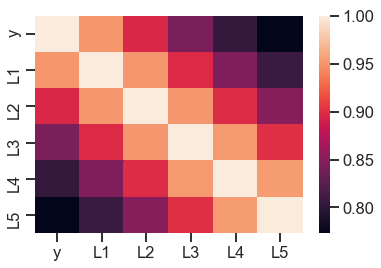

In [134]:
sns.heatmap(X.corr());

Second, we'd intuitively expect the $\beta_i$s to gradually decline to zero.
The immediately preceding period *should* be most important ($\beta_1$ is the largest coefficient in absolute value), followed by $\beta_2$, and $\beta_3$...
Looking at the regression summary and the bar graph below, this isn't the case (the cause is related to multicollinearity).

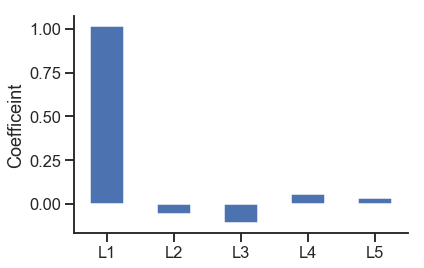

In [135]:
ax = res_lagged.params.drop(['Intercept', 'trend']).plot.bar(rot=0)
plt.ylabel('Coefficeint')
sns.despine()

Finally, our degrees of freedom drop since we lose two for each variable (one for estimating the coefficient, one for the lost observation as a result of the `shift`).
At least in (macro)econometrics, each observation is precious and we're loath to throw them away, though sometimes that's unavoidable.

#### Dectection of multicolinearity
>2. Insignificant regression coefficients for the affected variables in the multiple regression, but a rejection of the joint hypothesis that those coefficients are all zero (using an F-test)  

Variables jointly have a significant influence on dependent variable. But individually, only the most recent lagged term's coef is significant. Let's remove L1 and see how much this changes the coefs of L2 to L5. 

In [136]:
res_lagged.f_pvalue

5.92342348974542e-59

In [137]:
res_lagged.conf_int()

,0,1
Intercept,-113.638818,2170.900588
trend,-3.264523,3.701307
L1,0.837963,1.199215
L2,-0.314641,0.200794
L3,-0.368753,0.145531
L4,-0.201021,0.316855
L5,-0.147454,0.217836


In [147]:
res_lagged.params

Intercept    1028.630885
trend           0.218392
L1              1.018589
L2             -0.056924
L3             -0.111611
L4              0.057917
L5              0.035191
dtype: float64

> 1. Large changes in the estimated regression coefficients when a predictor variable is added or deleted.

When L1 is removed from model specification,  L2's coef has changed sign and went from -0.05 to 0.98.

In [138]:
mod_lagged_ex_l1 = smf.ols('y ~ trend + L2 + L3 + L4 + L5',
                     data=X.drop(columns='L1').assign(trend=np.arange(len(X))))
res_lagged_ex_l1 = mod_lagged_ex_l1.fit()

In [139]:
res_lagged_ex_l1.f_pvalue

1.629085590189265e-41

In [169]:
res_lagged_ex_l1.params.tolist()

[2112.4962692881236,
 0.6379415707829388,
 0.9839621078383904,
 -0.1737199605512697,
 -0.06016303906784448,
 0.1324197956340416]

> 7. Perturbing the data. Multicollinearity can be detected by adding random noise to the data and re-running the regression many times and seeing how much the coefficients change.

Below I added some noises at max 1% difference off the mean of y, reconstructed X given the noisy y, fit the lagged models and checked coefs. The changes in coefs are quite acceptable. It makes me wonder what exactly 'perturbing the data' in wiki means in the case of time-series data. Perturbing only the predictors? But predictors are just lagged varions of the dependent variable. Any noises added will change y and X in the same way. This method of checking multicolinearity is probably applicable to lagged distributed models for time series. 

In [190]:
y.describe()

count      132.000000
mean     17964.962733
std       1927.056644
min      13778.225806
25%      17089.427419
50%      17974.290323
75%      19561.370968
max      21073.516129
Name: fl_date, dtype: float64

In [234]:
np.random.seed(135)

def add_noise(y, diff_pct):
    max_diff = y.mean()*diff_pct
    noisy_y = y + np.random.uniform(low=-max_diff, high=max_diff, size=len(y))
    noisy_X = pd.concat([noisy_y.shift(i) for i in range(6)], 
                       axis=1, keys=['y'] + [f'L{i}' for i in range(1,6)]).dropna()
    return noisy_X

In [235]:
diff_pct = 0.01
add_noise(y, diff_pct).head()

,y,L1,L2,L3,L4,L5
2000-06-01,15580.288429,15550.047330,15572.519275,15469.395501,15265.642558,15234.642788
2000-07-01,15599.081024,15580.288429,15550.047330,15572.519275,15469.395501,15265.642558
2000-08-01,16017.215036,15599.081024,15580.288429,15550.047330,15572.519275,15469.395501
2000-09-01,15275.800353,16017.215036,15599.081024,15580.288429,15550.047330,15572.519275
2000-10-01,15824.303057,15275.800353,16017.215036,15599.081024,15580.288429,15550.047330


In [236]:
print(f"Add nosie at max {diff_pct*100:.1f}% off the mean")

Add nosie at max 1.0% off the mean


In [237]:
n_runs = 10
results=[]
for i in range(n_runs):
    if i > 0:
        noisy_X = add_noise(y, diff_pct)
    else:
        noisy_X = X
    mod_spec = smf.ols('y ~ trend + L1 + L2 + L3 + L4 + L5',
           data = noisy_X.assign(trend = np.arange(len(noisy_X))))
    mod_fit = mod_spec.fit()
    results.append(mod_fit.params)

In [209]:
pd.concat(results, axis=1)

,0,1,2,3,4,5,6,7,8,9
Intercept,1028.630885,1100.759281,1255.621018,872.412746,1010.544501,1168.368100,1081.371815,1195.464290,1020.465500,959.607748
trend,0.218392,-0.246435,0.782428,-0.166880,0.364836,0.357170,0.607644,0.513112,0.283786,-0.288293
L1,1.018589,0.971147,0.965986,1.007065,1.030845,0.972464,0.955749,0.984975,0.940335,1.035418
L2,-0.056924,0.010882,0.038403,-0.034200,-0.047751,-0.009073,-0.012699,-0.015441,0.052664,-0.080832
L3,-0.111611,-0.133808,-0.196813,-0.094997,-0.163206,-0.135240,-0.053585,-0.147200,-0.140034,-0.122964
L4,0.057917,0.063382,0.078757,0.008326,0.089365,0.082359,-0.022463,0.084940,0.029204,0.084017
L5,0.035191,0.028017,0.043206,0.066893,0.033693,0.025186,0.072006,0.026062,0.060429,0.034227


In [242]:
pd.concat(results, axis=1).T.describe()

,Intercept,trend,L1,L2,L3,L4,L5
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1052.645438,0.234156,0.990805,-0.031666,-0.103519,0.040136,0.046089
std,37.944418,0.075518,0.022185,0.042662,0.043454,0.040749,0.027316
min,994.422135,0.143362,0.949076,-0.107611,-0.177225,-0.020112,0.005469
25%,1029.005044,0.193537,0.977096,-0.059074,-0.126465,0.020298,0.030934
50%,1043.087036,0.220569,0.991124,-0.030778,-0.103291,0.032720,0.043069
75%,1073.534010,0.237443,1.009701,-0.002470,-0.088572,0.054591,0.058724
max,1126.194979,0.380028,1.018589,0.038135,-0.010480,0.106301,0.104340



### Autocorrelation

Another problem our lagged model suffered from is [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) (also know as serial correlation).
Roughly speaking, autocorrelation is when there's a clear pattern in the residuals of your regression (the observed minus the predicted).
Let's fit a simple model of $y = \beta_0 + \beta_1 T + \epsilon$, where `T` is the time trend (`np.arange(len(y))`).

In [244]:
# `Results.resid` is a Series of residuals: y - ŷ
mod_trend = sm.OLS.from_formula(
    'y ~ trend', data=y.to_frame(name='y')
                       .assign(trend=np.arange(len(y))))
res_trend = mod_trend.fit()

Residuals (the observed minus the expected, or $\hat{e_t} = y_t - \hat{y_t}$) are supposed to be [white noise](https://en.wikipedia.org/wiki/White_noise).
That's [one of the assumptions](https://en.wikipedia.org/wiki/Gauss–Markov_theorem) many of the properties of linear regression are founded upon.
In this case there's a correlation between one residual and the next: if the residual at time $t$ was above expectation, then the residual at time $t + 1$ is *much* more likely to be above average as well ($e_t > 0 \implies E_t[e_{t+1}] > 0$).

We'll define a helper function to plot the residuals time series, and some diagnostics about them.

In [246]:
def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

Calling it on the residuals from the linear trend:

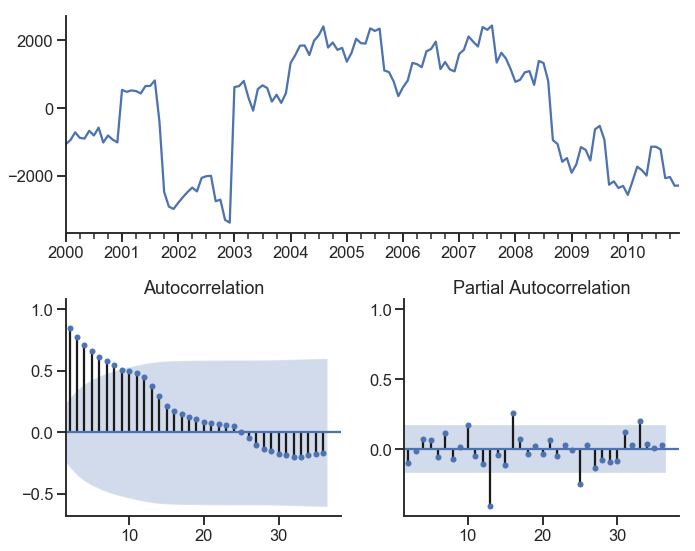

In [247]:
tsplot(res_trend.resid, lags=36);

The top subplot shows the time series of our residuals $e_t$, which should be white noise (but it isn't).
The bottom shows the [autocorrelation](https://www.otexts.org/fpp/2/2#autocorrelation) of the residuals as a correlogram.
It measures the correlation between a value and it's lagged self, e.g. $corr(e_t, e_{t-1}), corr(e_t, e_{t-2}), \ldots$.
The partial autocorrelation plot in the bottom-right shows a similar concept.
It's partial in the sense that the value for $corr(e_t, e_{t-k})$ is the correlation between those two periods, after controlling for the values at all shorter lags.

Autocorrelation is a problem in regular regressions like above, but we'll use it to our advantage when we setup an ARIMA model below.
The basic idea is pretty sensible: if your regression residuals have a clear pattern, then there's clearly some structure in the data that you aren't taking advantage of.
If a positive residual today means you'll likely have a positive residual tomorrow, why not incorporate that information into your forecast, and lower your forecasted value for tomorrow?
That's pretty much what ARIMA does.

It's important that your dataset be stationary, otherwise you run the risk of finding [spurious correlations](http://www.tylervigen.com/spurious-correlations).
A common example is the relationship between number of TVs per person and life expectancy.
It's not likely that there's an actual causal relationship there.
Rather, there could be a third variable that's driving both (wealth, say).
[Granger and Newbold (1974)](http://wolfweb.unr.edu/homepage/zal/STAT758/Granger_Newbold_1974.pdf) had some stern words for the econometrics literature on this.

> We find it very curious that whereas virtually every textbook on econometric methodology contains explicit warnings of the dangers of autocorrelated errors, this phenomenon crops up so frequently in well-respected applied work.

(:fire:), but in that academic passive-aggressive way.

The typical way to handle non-stationarity is to difference the non-stationary variable until is is stationary.

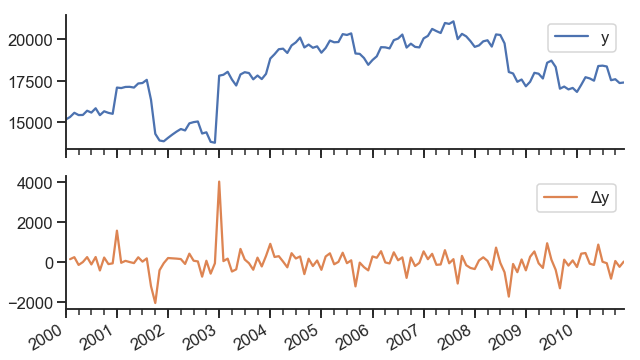

In [250]:
y.to_frame(name='y').assign(Δy=lambda x: x.y.diff()).plot(subplots=True, figsize=(10, 6))
sns.despine()

Our original series actually doesn't look *that* bad.
It doesn't look like nominal GDP say, where there's a clearly rising trend.
But we have more rigorous methods for detecting whether a series is non-stationary than simply plotting and squinting at it.
One popular method is the Augmented Dickey-Fuller test.
It's a statistical hypothesis test that roughly says:

$H_0$ (null hypothesis): $y$ is non-stationary, needs to be differenced

$H_A$ (alternative hypothesis): $y$ is stationary, doesn't need to be differenced

I don't want to get into the weeds on exactly what the test statistic is, and what the distribution looks like.
This is implemented in statsmodels as [`smt.adfuller`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).
The return type is a bit busy for me, so we'll wrap it in a `namedtuple`.

In [251]:
from collections import namedtuple

ADF = namedtuple("ADF", "adf pvalue usedlag nobs critical icbest")

In [252]:
ADF(*smt.adfuller(y))._asdict()

OrderedDict([('adf', -1.81697057036177),
             ('pvalue', 0.37206941862263243),
             ('usedlag', 12),
             ('nobs', 119),
             ('critical',
              {'1%': -3.4865346059036564,
               '5%': -2.8861509858476264,
               '10%': -2.579896092790057}),
             ('icbest', 1834.5420968370618)])

So we failed to reject the null hypothesis that the original series was non-stationary.
Let's difference it.

In [256]:
ADF(*smt.adfuller(y.diff().dropna()))._asdict()

OrderedDict([('adf', -2.431419451404095),
             ('pvalue', 0.13306412678848656),
             ('usedlag', 11),
             ('nobs', 119),
             ('critical',
              {'1%': -3.4865346059036564,
               '5%': -2.8861509858476264,
               '10%': -2.579896092790057}),
             ('icbest', 1822.0033716405712)])

This looks better.
It's not statistically significant at the 5% level, but who cares what statisticins say anyway.

We'll fit another OLS model of $\Delta y_t = \beta_0 + \beta_1 L \Delta y_{t-1} + e_t$

In [257]:
data = (y.to_frame(name='y')
         .assign(Δy=lambda df: df.y.diff())
         .assign(LΔy=lambda df: df.Δy.shift()))
mod_stationary = smf.ols('Δy ~ LΔy', data=data.dropna())
res_stationary = mod_stationary.fit()

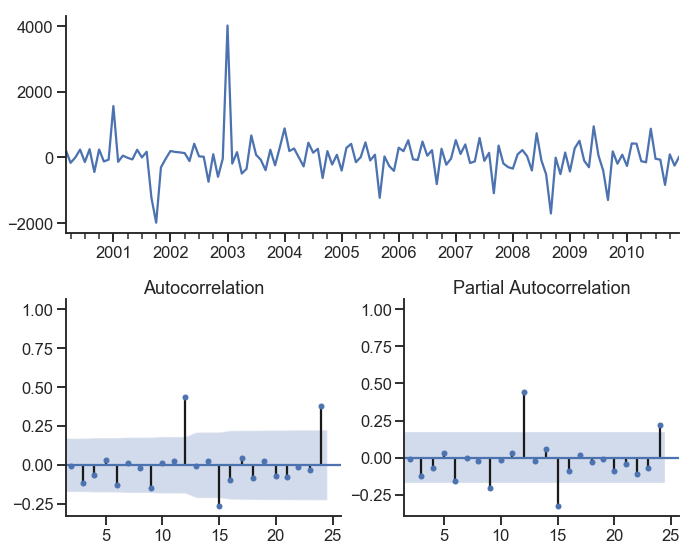

In [258]:
tsplot(res_stationary.resid, lags=24);

So we've taken care of multicolinearity, autocorelation, and stationarity, but we still aren't done.

## Seasonality

We have strong monthly seasonality:

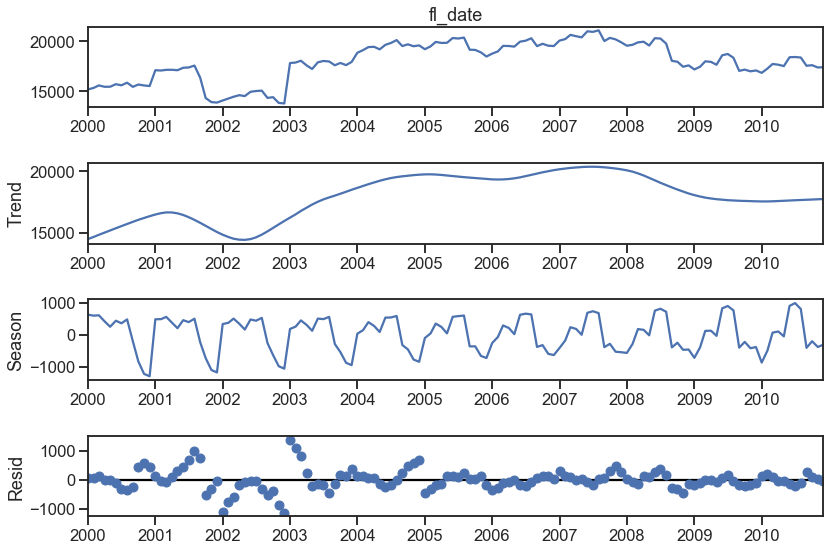

In [282]:
from statsmodels.tsa.seasonal import STL
stl = STL(y, seasonal=13)
res = stl.fit()
plt.rc('figure',figsize=(12,8))
fig = res.plot()

There are a few ways to handle seasonality.
We'll just rely on the `SARIMAX` method to do it for us.
For now, recognize that it's a problem to be solved.

## ARIMA

So, we've sketched the problems with regular old regression: multicollinearity, autocorrelation, non-stationarity, and seasonality.
Our tool of choice, `smt.SARIMAX`, which stands for Seasonal ARIMA with eXogenous regressors, can handle all these.
We'll walk through the components in pieces.

ARIMA stands for AutoRegressive Integrated Moving Average.
It's a relatively simple yet flexible way of modeling univariate time series.
It's made up of three components, and is typically written as $\mathrm{ARIMA}(p, d, q)$.

### [AutoRegressive](https://www.otexts.org/fpp/8/3)

The idea is to predict a variable by a linear combination of its lagged values (*auto*-regressive as in regressing a value on its past *self*).
An AR(p), where $p$ represents the number of lagged values used, is written as

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + e_t$$

$c$ is a constant and $e_t$ is white noise.
This looks a lot like a linear regression model with multiple predictors, but the predictors happen to be lagged values of $y$ (though they are estimated differently).

### Integrated

Integrated is like the opposite of differencing, and is the part that deals with stationarity.
If you have to difference your dataset 1 time to get it stationary, then $d=1$.
We'll introduce one bit of notation for differencing: $\Delta y_t = y_t - y_{t-1}$ for $d=1$.

### [Moving Average](https://www.otexts.org/fpp/8/4)

MA models look somewhat similar to the AR component, but it's dealing with different values.

$$y_t = c + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \ldots + \theta_q e_{t-q}$$

$c$ again is a constant and $e_t$ again is white noise.
But now the independent variables are the *residuals* from previous predictions.

### Combining

Putting that together, an ARIMA(1, 1, 1) process is written as

$$\Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_t e_{t-1} + e_t$$

Using *lag notation*, where $L y_t = y_{t-1}$, i.e. `y.shift()` in pandas, we can rewrite that as

$$(1 - \phi_1 L) (1 - L)y_t = c + (1 + \theta L)e_t$$

That was for our specific $\mathrm{ARIMA}(1, 1, 1)$ model. For the general $\mathrm{ARIMA}(p, d, q)$, that becomes

$$(1 - \phi_1 L - \ldots - \phi_p L^p) (1 - L)^d y_t = c + (1 + \theta L + \ldots + \theta_q L^q)e_t$$

We went through that *extremely* quickly, so don't feel bad if things aren't clear.
Fortunately, the model is pretty easy to use with statsmodels (using it *correctly*, in a statistical sense, is another matter).

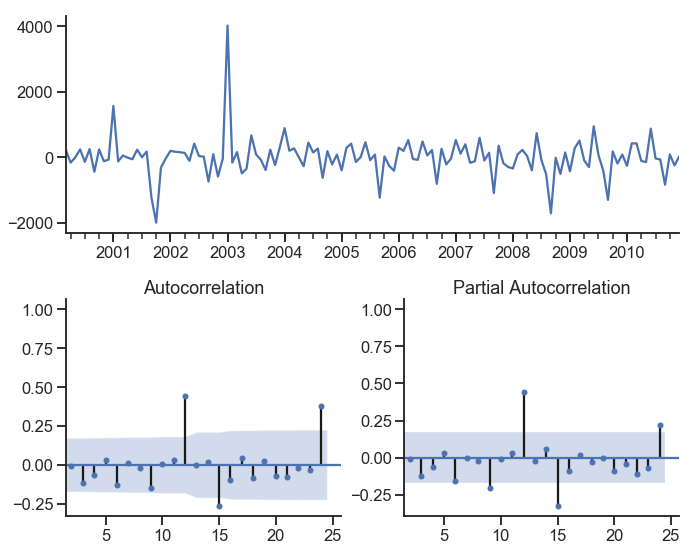

In [283]:
mod = smt.SARIMAX(y, trend='c', order=(1, 1, 1))
res = mod.fit()
tsplot(res.resid[2:], lags=24);

In [284]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                fl_date   No. Observations:                  132
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1020.795
Date:                Sun, 17 May 2020   AIC                           2049.589
Time:                        19:48:45   BIC                           2061.090
Sample:                    01-01-2000   HQIC                          2054.262
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.3144     81.416      0.176      0.860    -145.258     173.886
ar.L1          0.0678      3.727      0.018      0.985      -7.236       7.372
ma.L1         -0.0176      3.735     -0.005      0.996      -7.338       7.303
sigma2      3.533e+05   2.46e+04     14.383      0.000    3.05e+05    4.01e+05
===================================================================================
Ljung-Box (Q):                      105.09   Jarque-Bera (JB):              1619.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             1.90
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There's a bunch of output there with various tests, estimated parameters, and information criteria.
Let's just say that things are looking better, but we still haven't accounted for seasonality.

A seasonal ARIMA model is written as $\mathrm{ARIMA}(p,d,q)×(P,D,Q)_s$.
Lowercase letters are for the non-seasonal component, just like before. Upper-case letters are a similar specification for the seasonal component, where $s$ is the periodicity (4 for quarterly, 12 for monthly).

It's like we have two processes, one for non-seasonal component and one for seasonal components, and we multiply them together with regular algebra rules.

The general form of that looks like (quoting the [statsmodels docs](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) here)

$$\phi_p(L)\tilde{\phi}_P(L^S)\Delta^d\Delta_s^D y_t = A(t) + \theta_q(L)\tilde{\theta}_Q(L^s)e_t$$

where

- $\phi_p(L)$ is the non-seasonal autoregressive lag polynomial
- $\tilde{\phi}_P(L^S)$ is the seasonal autoregressive lag polynomial
- $\Delta^d\Delta_s^D$ is the time series, differenced  $d$ times, and seasonally differenced $D$ times.
- $A(t)$ is the trend polynomial (including the intercept)
- $\theta_q(L)$ is the non-seasonal moving average lag polynomial
- $\tilde{\theta}_Q(L^s)$  is the seasonal moving average lag polynomial

I don't find that to be very clear, but maybe an example will help.
We'll fit a seasonal ARIMA$(1,1,2)×(0, 1, 2)_{12}$.

So the nonseasonal component is

- $p=1$: period autoregressive: use $y_{t-1}$
- $d=1$: one first-differencing of the data (one month)
- $q=2$: use the previous two non-seasonal residual, $e_{t-1}$ and $e_{t-2}$, to forecast

And the seasonal component is

- $P=0$: Don't use any previous seasonal values
- $D=1$: Difference the series 12 periods back: `y.diff(12)`
- $Q=2$: Use the two previous seasonal residuals

In [285]:
mod_seasonal = smt.SARIMAX(y, trend='c',
                           order=(1, 1, 2), seasonal_order=(0, 1, 2, 12),
                           simple_differencing=False)
res_seasonal = mod_seasonal.fit()

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [286]:
res_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            fl_date   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -913.795
Date:                            Sun, 17 May 2020   AIC                           1841.591
Time:                                    19:51:47   BIC                           1861.045
Sample:                                01-01-2000   HQIC                          1849.491
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -39.9124     73.752     -0.541      0.588    -184.464     104.640
ar.L1         -0.9984      0.067    -14.954      0.000      -1.129      -0.868
ma.L1          1.0925      0.191      5.711      0.000       0.718       1.467
ma.L2          0.1006      0.124      0.812      0.417      -0.142       0.343
ma.S.L12      -0.7873      0.088     -8.918      0.000      -0.960      -0.614
ma.S.L24       0.2315      0.052      4.420      0.000       0.129       0.334
sigma2      2.269e+05   3.11e+04      7.293      0.000    1.66e+05    2.88e+05
===================================================================================
Ljung-Box (Q):                       26.59   Jarque-Bera (JB):               753.09
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -1.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

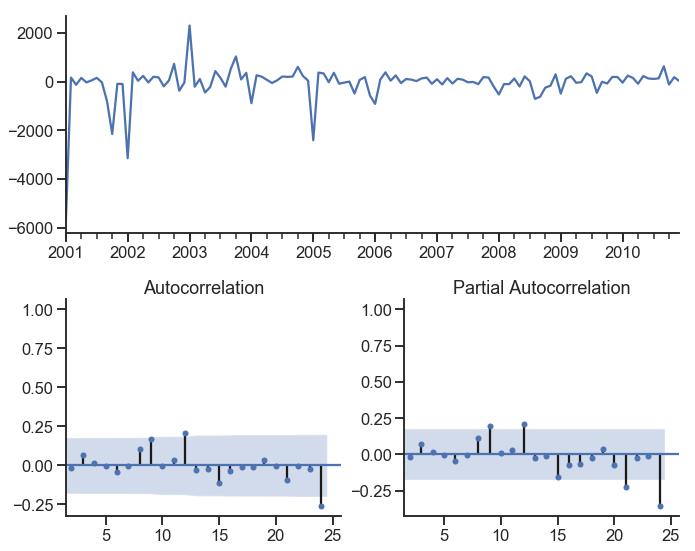

In [287]:
tsplot(res_seasonal.resid[12:], lags=24);

Things look much better now.

One thing I didn't really talk about is order selection. How to choose $p, d, q, P, D$ and $Q$.
R's forecast package does have a handy `auto.arima` function that does this for you.
Python / statsmodels don't have that at the minute.
The alternative seems to be experience (boo), intuition (boo), and good-old grid-search.
You can fit a bunch of models for a bunch of combinations of the parameters and use the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) or [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) to choose the best.
[Here](https://www.otexts.org/fpp/8/7) is a useful reference, and [this](http://stackoverflow.com/a/22770973) StackOverflow answer recommends a few options.


## Forecasting

Now that we fit that model, let's put it to use.
First, we'll make a bunch of one-step ahead forecasts.
At each point (month), we take the history up to that point and make a forecast for the next month.
So the forecast for January 2014 has available all the data up through December 2013.

In [288]:
pred = res_seasonal.get_prediction(start='2001-03-01')
pred_ci = pred.conf_int()

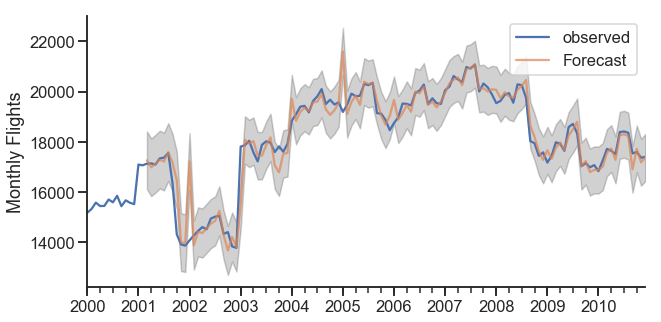

In [304]:
ax = y.plot(label='observed', figsize=(10,5))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_ylabel("Monthly Flights")
plt.legend()
sns.despine()

There are a few places where the observed series slips outside the 95% confidence interval.
The series seems especially unstable before 2005.

Alternatively, we can make *dynamic* forecasts as of some month (January 2013 in the example below).
That means the forecast from that point forward only use information available as of January 2013.
The predictions are generated in a similar way: a bunch of one-step forecasts.
Only instead of plugging in the *actual* values beyond January 2013, we plug in the *forecast* values.

In [295]:
pred_dy = res_seasonal.get_prediction(start='2002-03-01', dynamic='2008-01-01')
pred_dy_ci = pred_dy.conf_int()

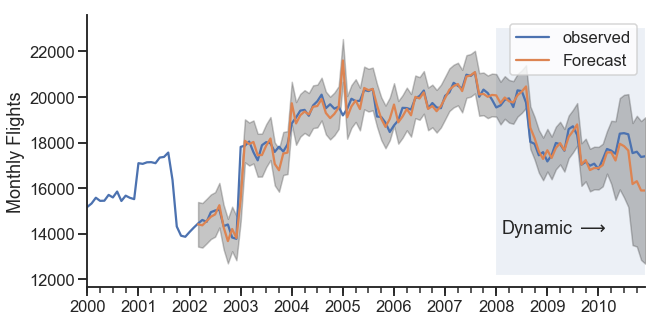

In [306]:
ax = y.plot(label='observed', figsize=(10,5))
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel("Monthly Flights")

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp('2008-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp('2008-02-01'), 14000))

plt.legend()
sns.despine()

## Resources

This is a collection of links for those interested.

### Time series modeling in Python

+ [Statsmodels Statespace Notebooks](http://www.statsmodels.org/dev/examples/index.html#statespace)
+ [Statsmodels VAR tutorial](http://www.statsmodels.org/dev/vector_ar.html#var)
- [ARCH Library by Kevin Sheppard](https://github.com/bashtage/arch)

### General Textbooks

- [Forecasting: Principles and Practice](https://www.otexts.org/fpp/): A great introduction
- [Stock and Watson](http://wps.aw.com/aw_stock_ie_3/178/45691/11696965.cw/): Readable undergraduate resource, has a few chapters on time series
- [Greene's Econometric Analysis](http://pages.stern.nyu.edu/~wgreene/Text/econometricanalysis.htm): My favorite PhD level textbook
- [Hamilton's Time Series Analysis](http://www.amazon.com/Time-Analysis-James-Douglas-Hamilton/dp/0691042896): A classic
- [Lutkehpohl's New Introduction to Multiple Time Series Analysis](http://www.amazon.com/New-Introduction-Multiple-Time-Analysis/dp/3540262393): Extremely dry, but useful if you're implementing this stuff

## Conclusion

Congratulations if you made it this far, this piece just kept growing (and I still had to cut stuff).
The main thing cut was talking about how `SARIMAX` is implemented on top of using statsmodels' statespace framework.
The statespace framework, developed mostly by Chad Fulton over the past couple years, is really nice.
You can pretty easily [extend it](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_local_linear_trend.html) with custom models, but still get all the benefits of the framework's estimation and results facilities.
I'd recommend reading the [notebooks](http://www.statsmodels.org/dev/examples/index.html#statespace).
We also didn't get to talk at all about Skipper Seabold's work on VARs, but maybe some other time.

As always, [feedback is welcome](https://twitter.com/tomaugspurger).